In [176]:
# Useful imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import networkit as nk
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
from src.helpers import *
from scipy.stats import normaltest
# import ipywidgets as widgets
# from ipywidgets import interact
pd.options.mode.chained_assignment = None  

In [177]:
ethn_div = pd.read_csv('generated/ethnicity_diversity.csv', sep=',')
gen_div = pd.read_csv('generated/gender_diversity.csv', sep=',')

### Functions

In [178]:
def common_movie_gender(str1, str2):  #check if two movies have at least one common genre
    # Convert string representation of lists to actual lists
    list1 = [genre.strip() for genre in str1.strip("[]").split(",")]
    list2 = [genre.strip() for genre in str2.strip("[]").split(",")]

    set1 = set(list1)
    set2 = set(list2)
    common_elements = set1.intersection(set2)

    if common_elements:
        return True
    else:
        return False
    
def min_max_scaling(df, column_name):
    for col in column_name:
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    return df

def binarize_diversity(df, column_name):
    median_value = df[column_name].median()
    df[column_name+'_binary'] = np.where(df[column_name] > median_value, 1, 0)
    return df

def add_propensity_score(df, formula_propensity_score,diversity_name,column_name):
    df = binarize_diversity(df,diversity_name)
    df = min_max_scaling(df,column_name)
    mod = smf.logit(formula= formula_propensity_score, data=df)
    res = mod.fit()
    df['Propensity_score'] = res.predict()
    return df

def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

def binarize(df, performance_param):
    if performance_param == 'box_office':
        median_value = df['movie_box_office_revenue'].median()
        df['movie_box_office_binary'] = np.where(df['movie_box_office_revenue'] > median_value, 1, 0)
    elif performance_param == 'rating':
        median_value = df['rating_average'].median()
        df['rating_binary'] = np.where(df['rating_average'] > median_value, 1, 0)
    else:
        print("Invalid performance parameter")
        return None
    return df

def compute_balance_df(df, perfomance_param): 
    # Separate the treatment and control groups
    if perfomance_param == 'box_office':
        treatment_df = df[df['movie_box_office_binary'] == 1]
        control_df = df[df['movie_box_office_binary'] == 0]

    elif perfomance_param == 'rating':
        treatment_df = df[df['rating_binary'] == 1]
        control_df = df[df['rating_binary'] == 0]
    else:
        print("Invalid performance parameter")
        return None
    
    # print("treatment size:",treatment_df.shape[0])
    # print("control size:",control_df.shape[0])

    # Create an empty undirected graph
    G = nx.Graph()

    # Loop through all the pairs of instances
    for control_id, control_row in control_df.iterrows():
        for treatment_id, treatment_row in treatment_df.iterrows():
            if (control_row['movie_languages_count'] == treatment_row['movie_languages_count']) and common_movie_gender(control_row['movie_genres'], treatment_row['movie_genres']):
                # Calculate the similarity 
                similarity = get_similarity(control_row['Propensity_score'],
                                            treatment_row['Propensity_score'])

                # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)

    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
    balanced_df = df.loc[matched]
    return balanced_df

def regression(df,formula,formula_propensity_score,performance_param,diversity_name,column_name):
    df = add_propensity_score(df, formula_propensity_score, diversity_name, column_name)
    df =binarize(df, performance_param)
    balanced_df = compute_balance_df(df,performance_param)
    mod = smf.ols(formula=formula, data=balanced_df)
    return balanced_df,mod

In [179]:

def filtering(df, performance_param):
    df_copy = df.copy()
    if (performance_param == 'box_office'):
        df_copy.dropna(subset=['movie_box_office_revenue'],inplace=True)
        return df_copy

    elif (performance_param == 'rating'):
        vote_threshold = 100
        df_copy.dropna(subset=['rating_average','movie_box_office_revenue'],inplace=True)
        df_bis = df_copy[df_copy['rating_count'] > vote_threshold]
        return df_bis

    else:
        print("Invalid parameters")
        
    

def year_release_split(df, number_parts):
    total_size = df.shape[0]
    share = int(total_size/(number_parts))
    cumulative_data = df['movie_release_year'].value_counts().sort_index().cumsum()
    cutoff = []
    for i in range(number_parts):
        relevant_data = cumulative_data[cumulative_data > (i)*share] 
        if not relevant_data.empty:
            cutoff.append(relevant_data.index[0])

    period_dataframes = {}
    for i in range(len(cutoff)):
        if i < len(cutoff)-1:
            period_df = df[
                (df['movie_release_year'] > cutoff[i]) &
                (df['movie_release_year'] <= cutoff[i+1])
            ]
        if i == len(cutoff)-1:
            period_df = df[
                (df['movie_release_year'] > cutoff[i])
            ]

        period_dataframes[f'df_period{i+1}'] = period_df
    return period_dataframes,cutoff  # period_dataframes['df_period1']


In [180]:
def plot_regression_line(balanced_dfs,mods,
                         cutoff,param_div,param_perf,xlabel='Ethnicity Diversity',ylabel='Box Office Revenue'):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 8))

    axes = axes.flatten()
    for i in range(10):
        df = balanced_dfs[i]
        mod = mods[i]
        intercept_coef = mod.fit().params['Intercept']
        ethnicity_coef = mod.fit().params[param_div]
        x_values = np.linspace(min(df[param_div]), max(df[param_div]), 100)
        y_values = intercept_coef + ethnicity_coef * x_values
        axes[i].plot(x_values, y_values, color='red', label='Regression Line')
        axes[i].scatter(df[param_div], df[param_perf], s=5, label='Data Points')
        axes[i].set_xlabel(f'{xlabel}: pval= {mod.fit().pvalues[param_div].round(3)}, intercept pval= {mod.fit().pvalues["Intercept"].round(3)}, \n intercept={mod.fit().params["Intercept"].round(3)} ,slope= {mod.fit().params[param_div].round(3)}')
        axes[i].set_ylabel(ylabel)
        axes[i].legend()
        if i < len(cutoff)-1:
            axes[i].set_title(f'{int(cutoff[i])} - {int(cutoff[i+1])}')
        if i == len(cutoff)-1:
            axes[i].set_title(f'{int(cutoff[i])} - {int(df["movie_release_year"].max())}')
    plt.tight_layout()
    plt.show()

### Ethnicity-Box office

In [181]:
ethn_div_filter = filtering(ethn_div,'box_office')
print('Size of Ethnicity :',ethn_div_filter.shape[0])
nbr = 10
period_df ,cutoff = year_release_split(ethn_div_filter, nbr)

Size of Ethnicity : 4683


In [182]:
# Create an empty list to store the results
results = []

# Define the columns for propensity score
columns = ['movie_languages_count', 'rating_average']

# Iterate over periods
for period_num in range(1, 11):
    print(period_num,"period_num")
    period_key = f'df_period{period_num}'
    
    # Perform regression for each period
    balanced_df, mod = regression(
        period_df[period_key],
        formula='movie_box_office_revenue ~ ethnicity_diversity',
        formula_propensity_score='ethnicity_diversity ~ ' + ' + '.join(columns),
        performance_param='box_office',
        diversity_name='ethnicity_diversity',
        column_name=columns
    )
    
    # Store the results in a tuple and append to the list
    result = (balanced_df, mod)
    results.append(result)

# Extract the results for each period
balanced_dfs, mods = zip(*results)


1 period_num
Optimization terminated successfully.
         Current function value: 0.683615
         Iterations 4
2 period_num
Optimization terminated successfully.
         Current function value: 0.662985
         Iterations 4
3 period_num
Optimization terminated successfully.
         Current function value: 0.649649
         Iterations 4
4 period_num
Optimization terminated successfully.
         Current function value: 0.633012
         Iterations 4
5 period_num
Optimization terminated successfully.
         Current function value: 0.588281
         Iterations 5
6 period_num
Optimization terminated successfully.
         Current function value: 0.580407
         Iterations 5
7 period_num
Optimization terminated successfully.
         Current function value: 0.596871
         Iterations 5
8 period_num
Optimization terminated successfully.
         Current function value: 0.632317
         Iterations 5
9 period_num
Optimization terminated successfully.
         Current function val

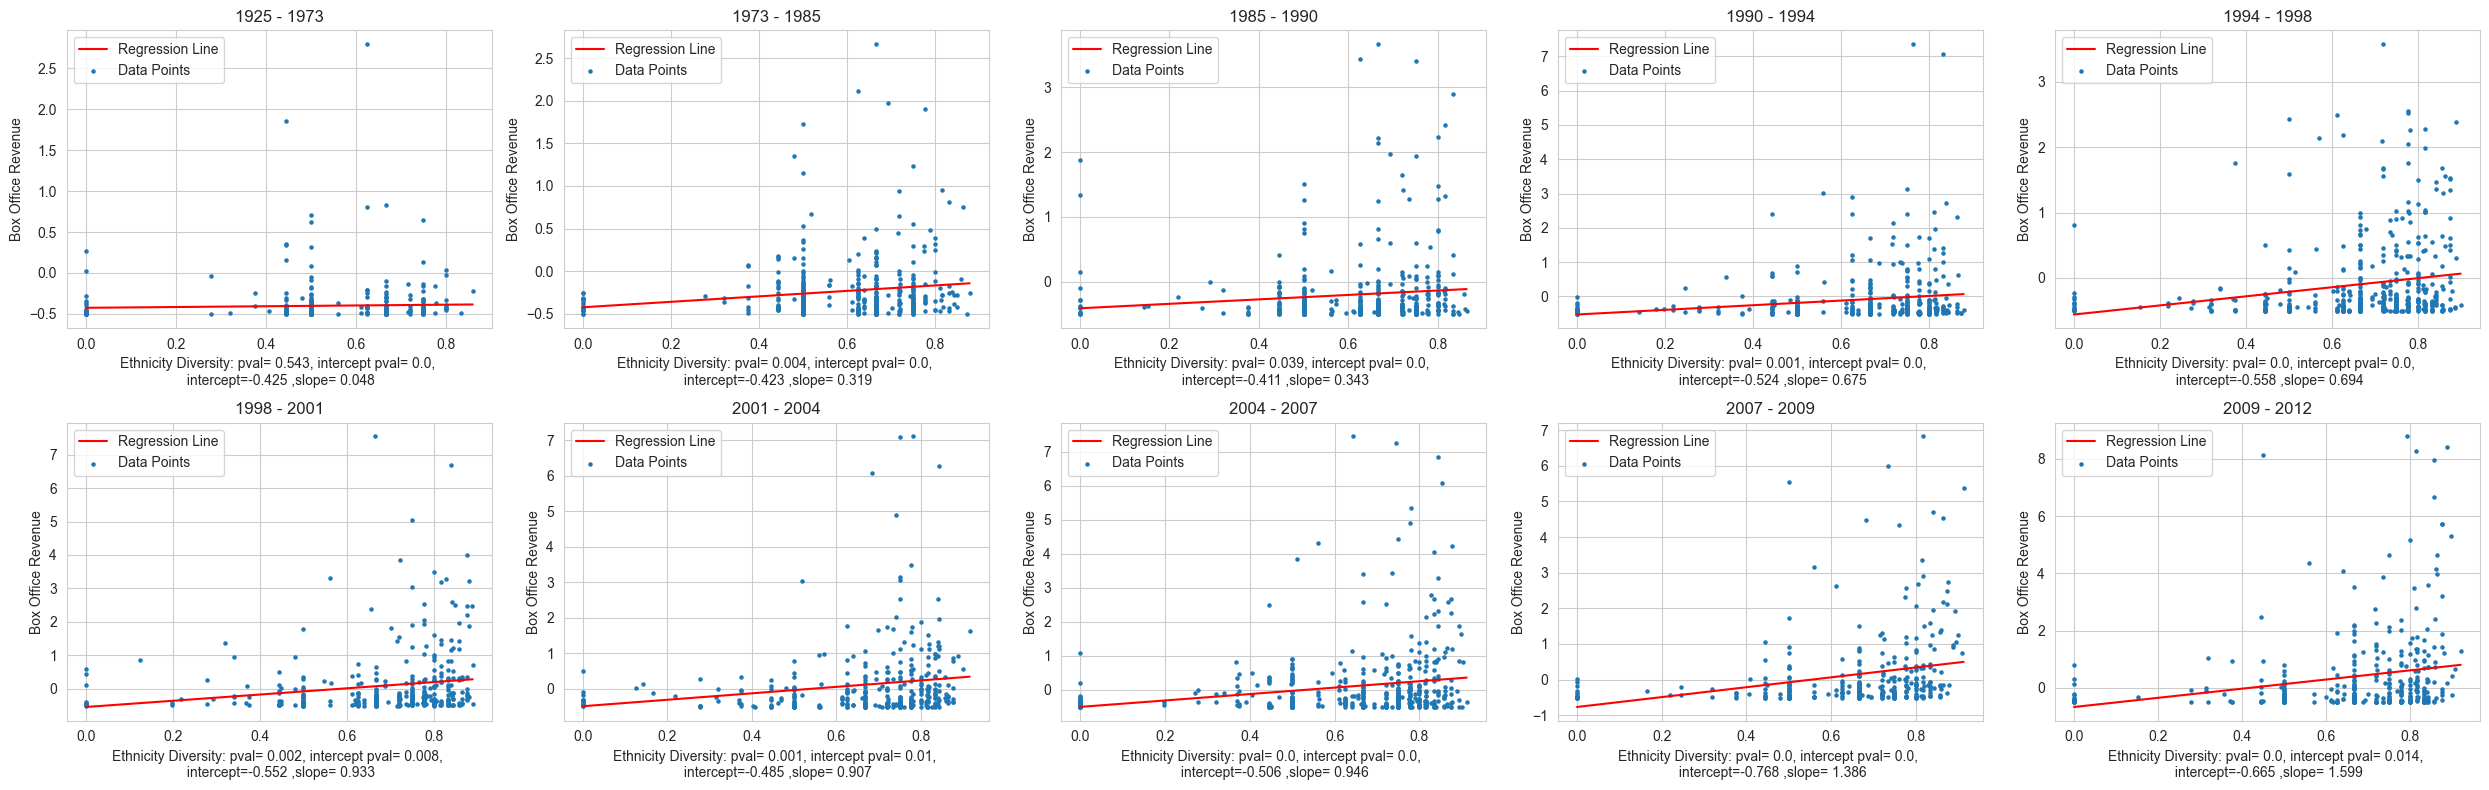

In [183]:
plot_regression_line(balanced_dfs,mods,
                     cutoff,'ethnicity_diversity','movie_box_office_revenue')

### Gender - Box office

In [184]:
gen_div_filter = filtering(gen_div,'box_office')
print('Size of Gender :',gen_div_filter.shape[0])
period_df_gb ,cutoff_gb = year_release_split(gen_div_filter, 10)


Size of Gender : 5600


In [185]:
results = []

# Define the columns for propensity score
columns = ['movie_languages_count', 'rating_average']

# Iterate over periods
for period_num in range(1, 11):
    print(period_num,"period_num")
    period_key = f'df_period{period_num}'
    
    # Perform regression for each period
    balanced_df, mod = regression(
        period_df_gb[period_key],
        formula='movie_box_office_revenue ~ gender_diversity',
        formula_propensity_score='gender_diversity ~ ' + ' + '.join(columns),
        performance_param='box_office',
        diversity_name='gender_diversity',
        column_name=columns
    )
    
    # Store the results in a tuple and append to the list
    result = (balanced_df, mod)
    results.append(result)

# Extract the results for each period
balanced_dfs_gb, mods_gb = zip(*results)

1 period_num
Optimization terminated successfully.
         Current function value: 0.645465
         Iterations 4
2 period_num
Optimization terminated successfully.
         Current function value: 0.625520
         Iterations 4
3 period_num
Optimization terminated successfully.
         Current function value: 0.631006
         Iterations 4
4 period_num
Optimization terminated successfully.
         Current function value: 0.641170
         Iterations 4
5 period_num
Optimization terminated successfully.
         Current function value: 0.639523
         Iterations 4
6 period_num
Optimization terminated successfully.
         Current function value: 0.647292
         Iterations 4
7 period_num
Optimization terminated successfully.
         Current function value: 0.643967
         Iterations 4
8 period_num
Optimization terminated successfully.
         Current function value: 0.654683
         Iterations 4
9 period_num
Optimization terminated successfully.
         Current function val

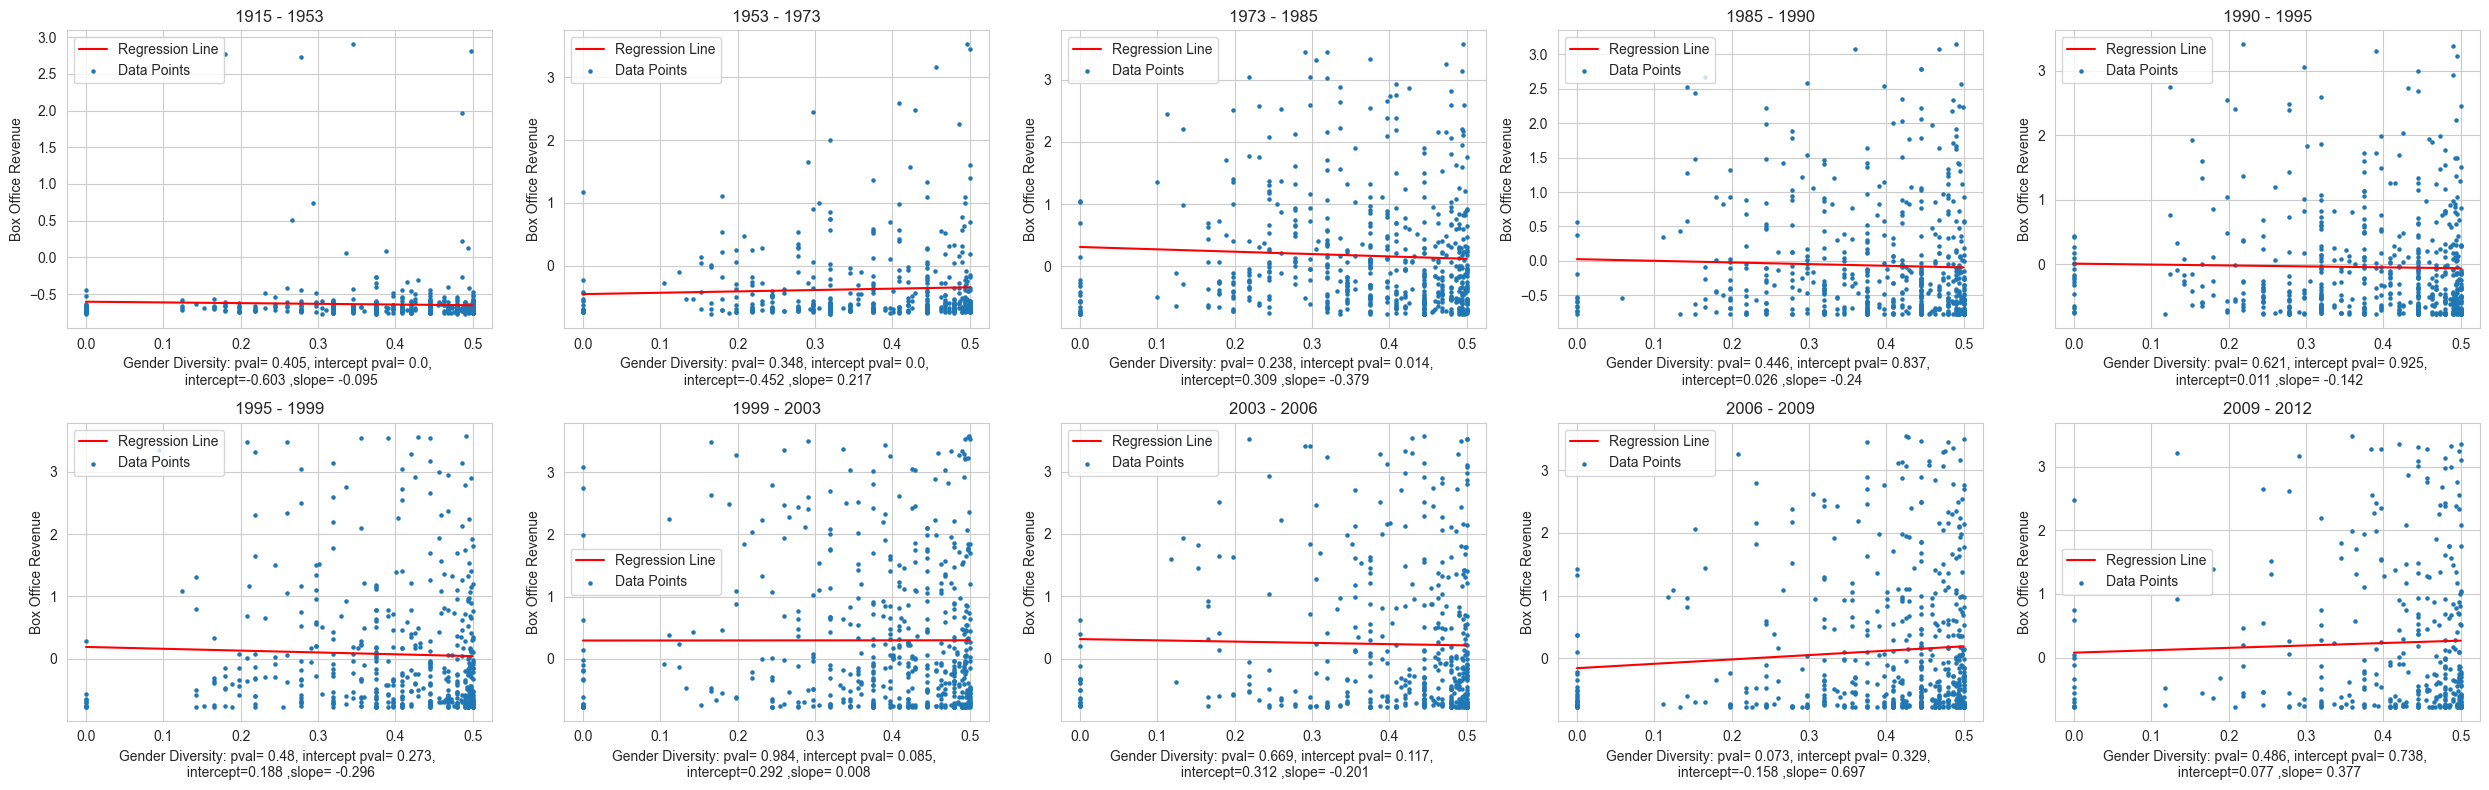

In [186]:
plot_regression_line(balanced_dfs_gb,mods_gb,cutoff_gb,'gender_diversity',
                     'movie_box_office_revenue', 'Gender Diversity')

### Ethnicity - Ratings

In [187]:
ethn_div_filter_r = filtering(ethn_div,'rating')
print('Size of Gender :',ethn_div_filter_r.shape[0])
period_df_er ,cutoff_er = year_release_split(ethn_div_filter_r, 10)


Size of Gender : 3534


In [188]:
results = []

# Define the columns for propensity score
columns = ['movie_languages_count', 'movie_box_office_revenue']

# Iterate over periods
for period_num in range(1, 11):
    print(period_num,"period_num")
    period_key = f'df_period{period_num}'
    
    # Perform regression for each period
    balanced_df, mod = regression(
        period_df_er[period_key],
        formula='rating_average ~ ethnicity_diversity',
        formula_propensity_score='ethnicity_diversity ~ ' + ' + '.join(columns),
        performance_param='rating',
        diversity_name='ethnicity_diversity',
        column_name=columns
    )
    
    # Store the results in a tuple and append to the list
    result = (balanced_df, mod)
    results.append(result)

# Extract the results for each period
balanced_dfs_er, mods_er = zip(*results)

1 period_num
Optimization terminated successfully.
         Current function value: 0.667753
         Iterations 4
2 period_num
Optimization terminated successfully.
         Current function value: 0.634331
         Iterations 5
3 period_num
Optimization terminated successfully.
         Current function value: 0.620515
         Iterations 5
4 period_num
Optimization terminated successfully.
         Current function value: 0.592741
         Iterations 5
5 period_num
Optimization terminated successfully.
         Current function value: 0.536268
         Iterations 6
6 period_num
Optimization terminated successfully.
         Current function value: 0.559327
         Iterations 5
7 period_num
Optimization terminated successfully.
         Current function value: 0.597385
         Iterations 5
8 period_num
Optimization terminated successfully.
         Current function value: 0.580996
         Iterations 5
9 period_num
Optimization terminated successfully.
         Current function val

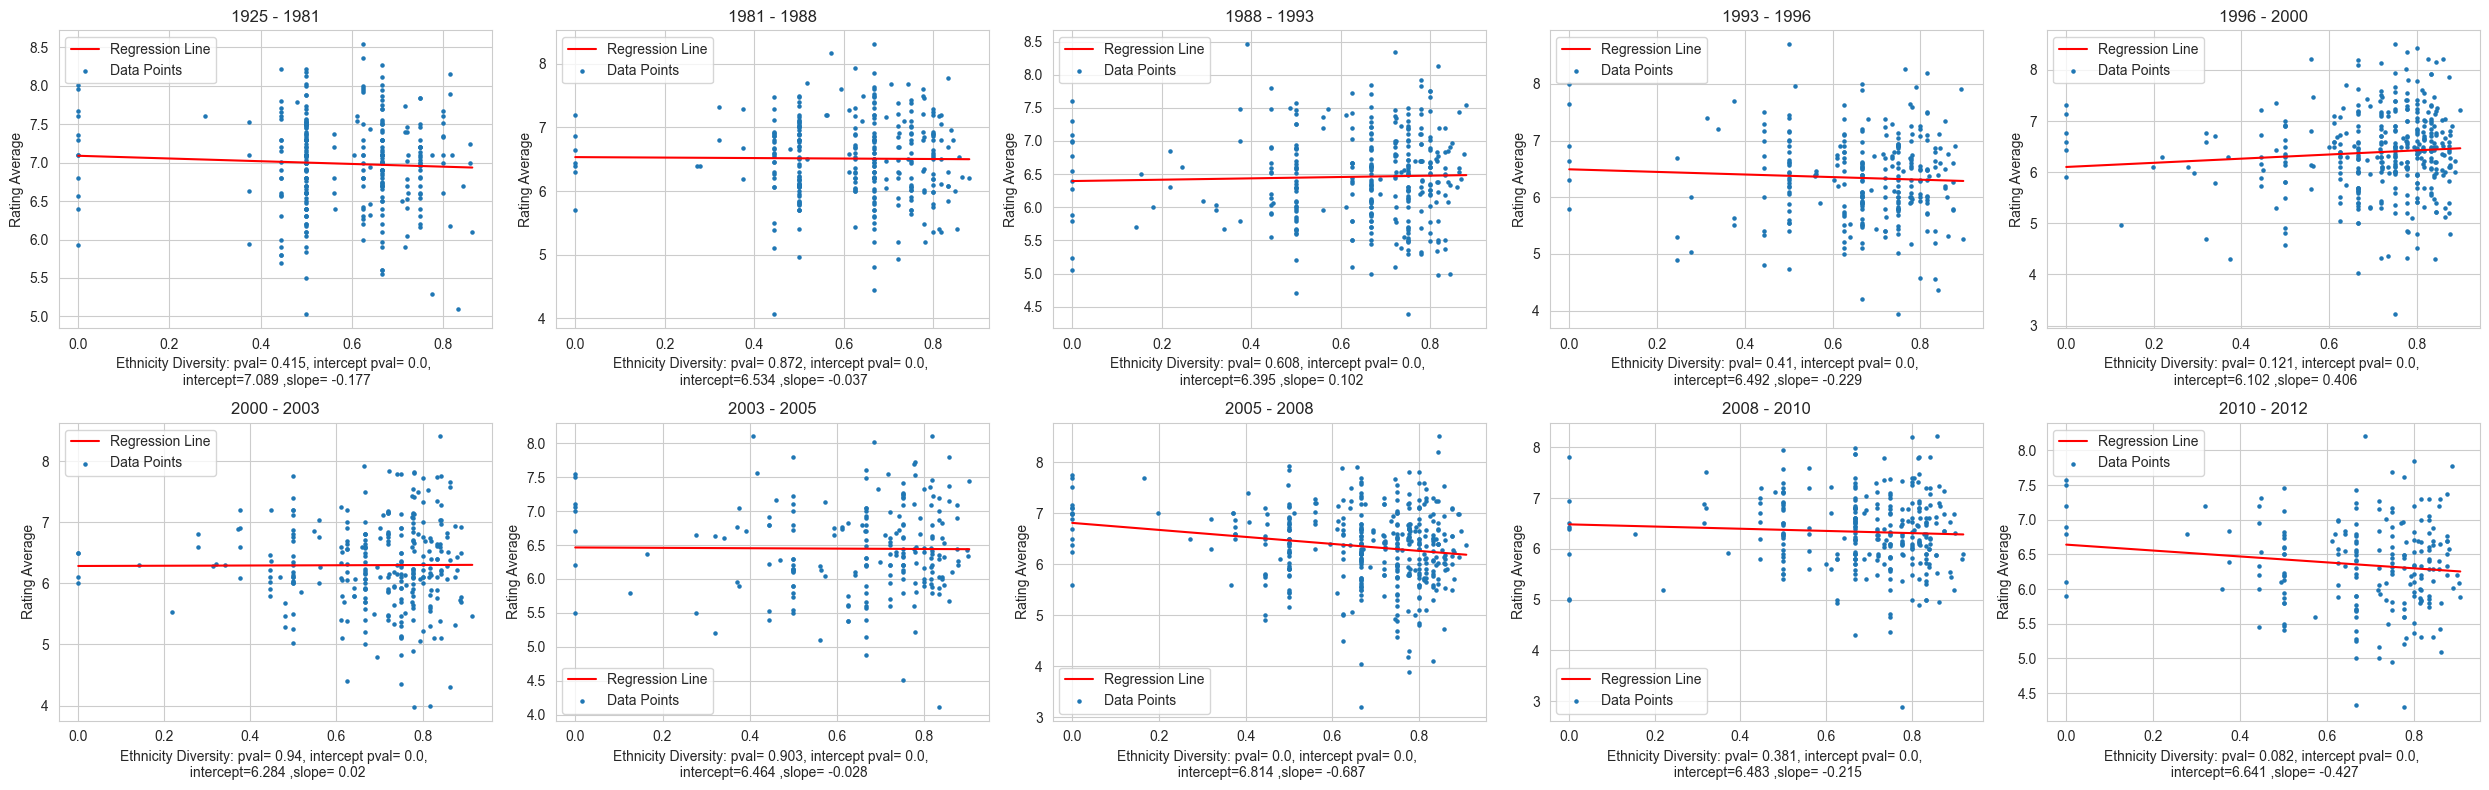

In [189]:
plot_regression_line(
    balanced_dfs_er,mods_er,
    cutoff_er,'ethnicity_diversity', 'rating_average', 'Ethnicity Diversity', 'Rating Average'
)


### Gender - Ratings

In [190]:
gen_div_filter_r = filtering(gen_div,'rating')
print('Size of Gender :',gen_div_filter_r.shape[0])
period_df_gr ,cutoff_gr = year_release_split(gen_div_filter_r, 10)

Size of Gender : 3406


In [191]:
results = []

# Define the columns for propensity score
columns = ['movie_languages_count', 'movie_box_office_revenue']

# Iterate over periods
for period_num in range(1, 11):
    print(period_num,"period_num")
    period_key = f'df_period{period_num}'
    
    # Perform regression for each period
    balanced_df, mod = regression(
        period_df_gb[period_key],
        formula='rating_average ~ gender_diversity',
        formula_propensity_score='gender_diversity ~ ' + ' + '.join(columns),
        performance_param='rating',
        diversity_name='gender_diversity',
        column_name=columns
    )
    
    # Store the results in a tuple and append to the list
    result = (balanced_df, mod)
    results.append(result)

# Extract the results for each period
balanced_dfs_gr, mods_gr = zip(*results)

1 period_num
Optimization terminated successfully.
         Current function value: 0.645392
         Iterations 4
2 period_num
Optimization terminated successfully.
         Current function value: 0.626449
         Iterations 4
3 period_num
Optimization terminated successfully.
         Current function value: 0.631014
         Iterations 4
4 period_num
Optimization terminated successfully.
         Current function value: 0.641073
         Iterations 4
5 period_num
Optimization terminated successfully.
         Current function value: 0.639572
         Iterations 4
6 period_num
Optimization terminated successfully.
         Current function value: 0.647286
         Iterations 4
7 period_num
Optimization terminated successfully.
         Current function value: 0.644282
         Iterations 4
8 period_num
Optimization terminated successfully.
         Current function value: 0.654588
         Iterations 4
9 period_num
Optimization terminated successfully.
         Current function val

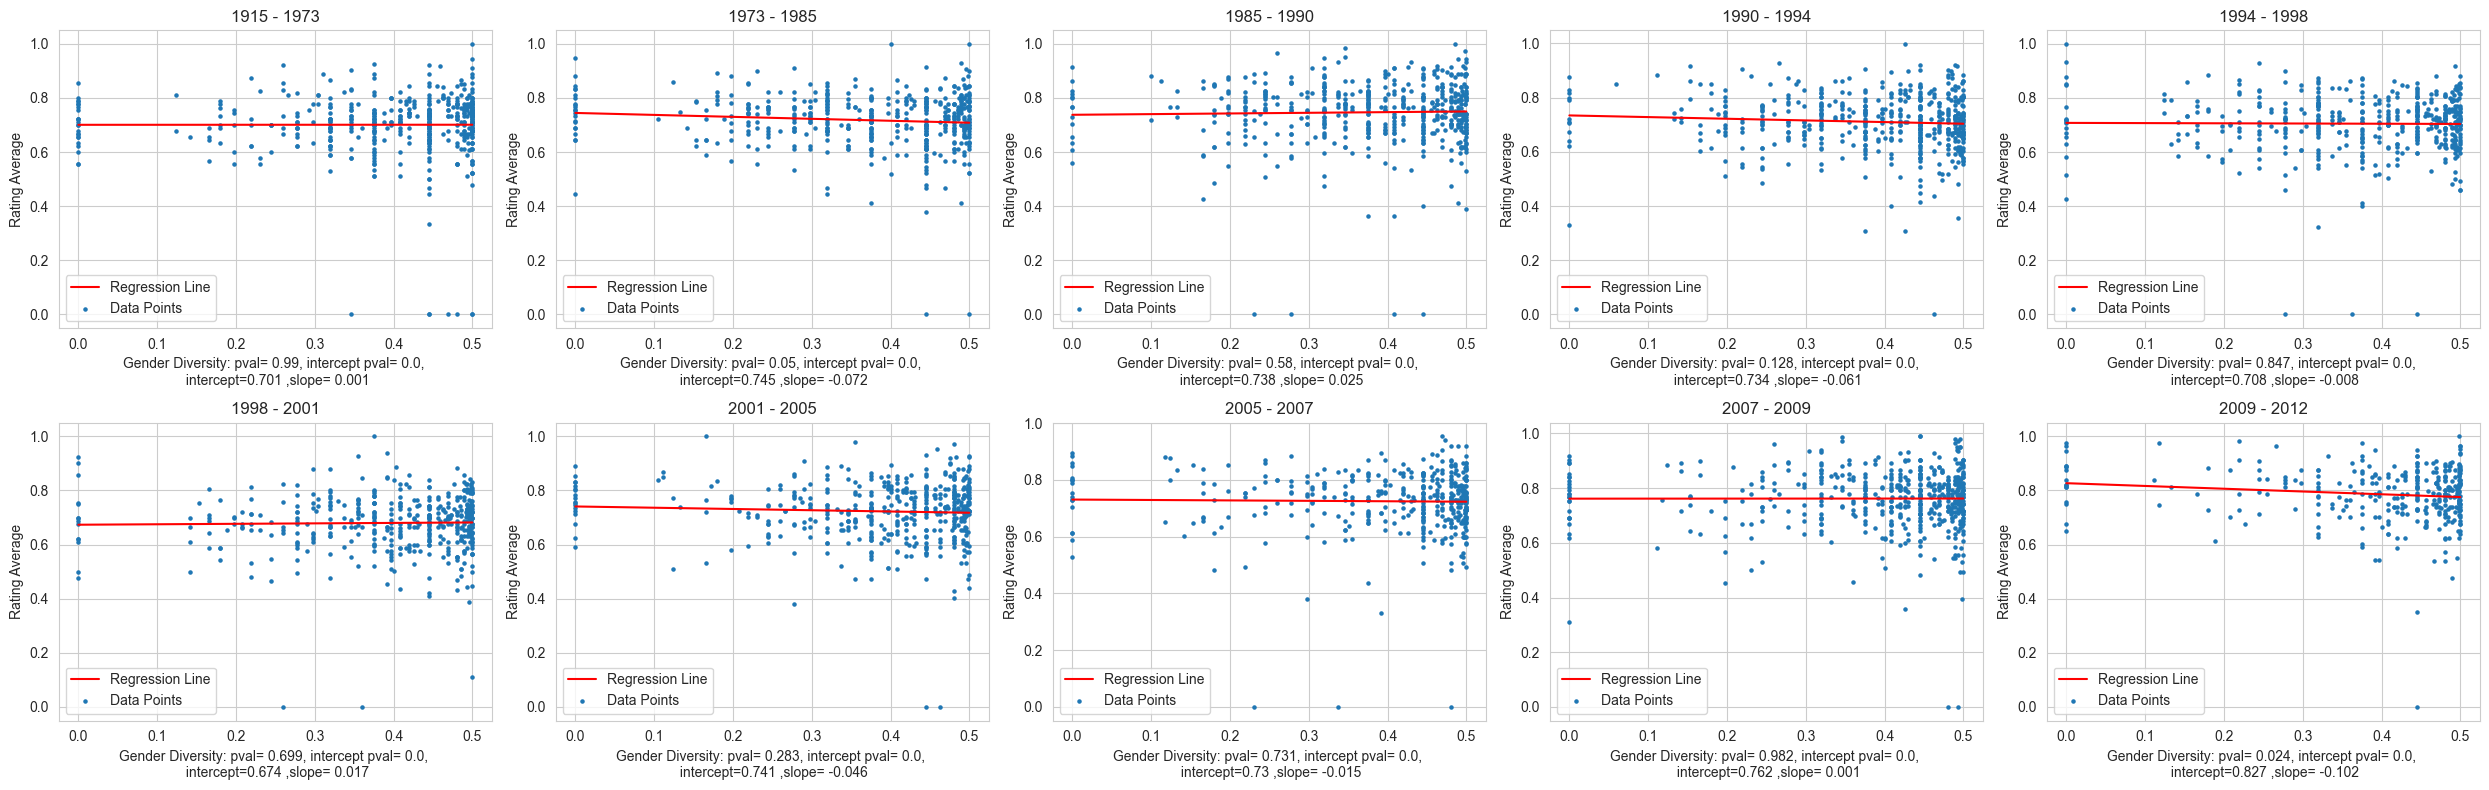

In [192]:
plot_regression_line(
    balanced_dfs_gr,mods_gr,
    cutoff_gr,'gender_diversity', 'rating_average', 'Gender Diversity', 'Rating Average'
)
